# TNG Preparation

This notebook takes a halo from the [TNG 300-1](https://www.tng-project.org/about/) simulation and generates simulated X-ray observations of it using [PyXSim](https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/). This observations may then be input into Bayes-X for demonstrating and testing the analysis proceedure.

## Halo Selection

Each run has 100 snapshots avaliable, at different redshifts. However, most snapshots are stored in a minified format that lacks some of the data we used to generate simulated observations. The snapshots retained in full are:

| Snap | Scale factor | Redshift |
|:----:|:------------:|:--------:|
|   2  |    0.0769    |    12    |
|   3  |    0.0833    |    11    |
|   4  |    0.0909    |    10    |
|   6  |      0.1     |     9    |
|   8  |    0.1111    |     8    |
|  11  |     0.125    |     7    |
|  13  |    0.1429    |     6    |
|  17  |    0.1667    |     5    |
|  21  |      0.2     |     4    |
|  25  |     0.25     |     3    |
|  33  |    0.3333    |     2    |
|  40  |      0.4     |    1.5   |
|  50  |      0.5     |     1    |
|  59  |    0.5882    |    0.7   |
|  67  |    0.6667    |    0.5   |
|  72  |    0.7143    |    0.4   |
|  78  |    0.7692    |    0.3   |
|  84  |    0.8333    |    0.2   |
|  91  |    0.9091    |    0.1   |
|  99  |       1      |     0    |

**Select halo here**

In [1]:
# Specify halo here
snapshot_id = 91
halo_id = 0


We load our API key and some helper functions. There's a basic cache becausing downloading cutouts takes a while.

There is possibly room to shrink the download by reducing the included fields (which can be incorporated in the api call) - this need futher investigation.

In [2]:
from os import getenv
from os import makedirs
from pathlib import Path
from uuid import uuid1

import requests
from tqdm.notebook import tqdm
from dotenv import load_dotenv

# Load TNG API key
# This looks for a .env file in this or a parent folder and
# loads environment variables from it.
# It does not override existing env vars.
load_dotenv()

# This gets it from the environment, which may have
# been modified by load_dotenv
# You could specify it here but don't commit it to git!
api_key = getenv("TNG_API_KEY")


# The files we are working with can be large so we'll make a basic
# cache to ease the load on the TNG Project servers.# type: ignore
# yt exports the types in a way that makes Pylance think they're private, leading to endless warnings.

def query_cache(filename: str, cache_path=Path(".cache")):
    """Look for file in cache"""
    file_path = Path(cache_path, filename)

    if file_path.is_file():
        return True, file_path
    else:
        return False, file_path


def update_cache(filename: str, content, cache_path=Path(".cache"), overwrite=False):
    """Add file to cache"""
    if not cache_path.is_dir():
        print(f"Making cache directory at {cache_path}")
        makedirs(cache_path)

    file_path = Path(cache_path, filename)

    if file_path.exists():
        if overwrite:
            print(f"Overwriting existing cache file {file_path}.")
        else:
            raise FileExistsError(f"Cache file {file_path} already exists.")

    write_mode = "wb"
    if isinstance(content, requests.Response):
        # Read binary/text from request and access content
        if "text" in content.headers["Content-Type"]:
            write_mode = "w"
        content = content.content
    elif isinstance(content, Path):
        # If we're passed a file just move it
        # This is good for large temp files we don't want to read into memory
        print(f"Moving {content} to cache as {file_path}")
        content.rename(file_path)
        return file_path

    with file_path.open(write_mode) as f:
        print(f"Caching {file_path}")
        f.write(content)

    return file_path


def get_halo(snapshot: int, halo: int, simulation="TNG300-1"):
    "Get local path to halo files, downloading it if required. Fetches cutout and `info.json`."
    base_url = f"http://www.tng-project.org/api/{simulation}/snapshots/{snapshot}/halos/{halo}/"
    headers = {"api-key": api_key}

    base_filename = f"{simulation}_snapshot{snapshot_id}_halo{halo_id}_"

    # First get info file for halo
    info_filename = base_filename + "_info.json"
    in_cache, info_path = query_cache(info_filename)

    if not in_cache:
        info_url = base_url + "info.json"
        print(f"Downloading info.json for halo from {info_url}")
        r = requests.get(info_url, headers=headers)  # type: ignore
        r.raise_for_status()  # raise exception on error
        info_path = update_cache(info_filename, r)

    # Then get the halo cutout
    halo_filename = base_filename + "_cutout.hdf5"
    in_cache, halo_path = query_cache(halo_filename)

    if not in_cache:
        tmp_file = Path(f"tmp_{uuid1()}.hdf5")
        cutout_url = base_url + "cutout.hdf5"
        print(f"Downloading cutout for halo from {cutout_url} to {tmp_file}")
        r = requests.get(cutout_url, headers=headers, stream=True)  # type: ignore
        # Fancy progress bar
        with tqdm.wrapattr(
            open(tmp_file, "wb"),
            "write",
            miniters=1,
            desc=f"Downloading cutout",
            total=int(r.headers.get("content-length", 0)),
        ) as fout:
            for chunk in r.iter_content(chunk_size=4096):
                fout.write(chunk)
        update_cache(halo_filename, tmp_file)

    return info_path, halo_path

Here we actually fetch the halo. This returns the path to the file location in the cache, downloading it if required. We grab both the HDF5 file and the info file for some precomputed values.

Values from `info.json` may be included somewhere in the cutout file - investigate.

In [3]:
info_path, halo_path = get_halo(snapshot_id, halo_id)

We then load it into Python with yt. Before doing so we define an additional field for solar metallicity. This is because, according to the [TNG data specification](https://www.tng-project.org/data/docs/specifications):
> [GFM_Metallicity is] the ratio MZ/Mtotal where MZ is the total mass all metal elements (above He). Is NOT in solar units. To convert to solar metallicity, divide by 0.0127 (the primordial solar metallicity).

PyXsim assumes solar metallicities, as best I can tell, so we need this correction.

In [4]:
import yt
from json import load as load_json

@yt.derived_field(name=("gas", "solar_metallicity"), sampling_type="particle", units="dimensionless")
def _solar_metallicity(field, data):
    return data['PartType0', 'GFM_Metallicity'] / 0.0127

with info_path.open() as f:
    info = load_json(f)

ds = yt.load(halo_path)

yt : [INFO     ] 2023-04-28 15:41:16,170 Calculating time from 9.096e-01 to be 3.934e+17 seconds
yt : [INFO     ] 2023-04-28 15:41:16,223 Parameters: current_time              = 3.934088884834162e+17 s
yt : [INFO     ] 2023-04-28 15:41:16,223 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-04-28 15:41:16,224 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-28 15:41:16,225 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2023-04-28 15:41:16,225 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-04-28 15:41:16,225 Parameters: current_redshift          = 0.09940180263022191
yt : [INFO     ] 2023-04-28 15:41:16,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2023-04-28 15:41:16,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2023-04-28 15:41:16,226 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-04-28 15:41:16,226 Parameters: hubble_const

## Plots

First we draw a few nice plots of the data. This helps us get an idea of the cluster shape and structure.

**Select projection normal here**

In [5]:
projection_normal = 'z' # vector normal to the plane of projection

We try to locate the edge of the cluster with a method so we can enclose it in a sphere.

In [6]:
# type: ignore
# Set these values here so the edge radius doesn't reset every time

# From the data specs:
# GroupPos = spatial position within the periodic box (of the particle with the minimum gravitational potential energy). Comoving coordinate.
from unyt import unyt_array, unyt_quantity
center = info['GroupPos']
center = unyt_array(center, 'kpccm/h', registry=ds.unit_registry)
r200 = unyt_quantity(info["Group_R_Crit200"], "kpccm/h", registry=ds.unit_registry)
r500 = unyt_quantity(info["Group_R_Crit500"], "kpccm/h", registry=ds.unit_registry)

dm = 1
r = 3 * r200
dr = 0.8 * r200

mt = ds.r[:,:,:].sum(('gas', 'mass'))
dx = mt

yt : [INFO     ] 2023-04-28 15:41:16,341 Allocating for 7.236e+07 particles
Initializing coarse index : 100%|██████████| 152/152 [00:03<00:00, 40.84it/s]
yt : [INFO     ] 2023-04-28 15:41:20,089 Updating index_order2 from 2 to 4
Initializing refined index: 100%|██████████| 152/152 [00:22<00:00,  6.82it/s]


In [7]:
# This is a crude and slow way to find the cluster edge
sp1 = ds.sphere(center, (1, 'kpccm/h'))
while dx > 0.0001*mt or abs(dr) > 50:
    r += dr
    sp2 = sp1
    sp1 = ds.sphere(center, r) 
    dx = sp1.sum(("gas", "mass")).in_units('Msun') - sp2.sum(("gas", "mass")).in_units('Msun')

    print(f"dx: {dx} at radius {r} with dr: {dr}")
    if dx == 0:
        dr = -abs(dr / 2)
    else:
        dr = min(abs(mt / dx * r), 1.5*r200)

sp = ds.sphere(center, r)

dx: 339633084663245.75 Msun at radius 6423.623999023437 kpccm/h with dr: 1352.34189453125 kpccm/h
dx: 3094610975024.75 Msun at radius 8959.26505126953 kpccm/h with dr: 2535.6410522460938 kpccm/h
dx: 0.0 Msun at radius 11494.906103515625 kpccm/h with dr: 2535.6410522460938 kpccm/h
dx: 0.0 Msun at radius 10227.085577392578 kpccm/h with dr: -1267.8205261230469 kpccm/h
dx: 0.0 Msun at radius 9593.175314331054 kpccm/h with dr: -633.9102630615234 kpccm/h
dx: 0.0 Msun at radius 9276.220182800293 kpccm/h with dr: -316.9551315307617 kpccm/h
dx: 0.0 Msun at radius 9117.742617034912 kpccm/h with dr: -158.47756576538086 kpccm/h
dx: 0.0 Msun at radius 9038.503834152221 kpccm/h with dr: -79.23878288269043 kpccm/h


In [8]:
def annotated_sphere_labeled(plot, center, radius, text):
    """Helper function to draw a circle on a plot and give it a radius on the right edge"""
    plot.annotate_sphere(center, radius=radius)
    radius_edge = center + radius / 2
    plot.annotate_text(radius_edge, text=text)

def annotate_spheres(plot, center, r200, r500, rsp):
    """Apply standard plot annotations"""
    annotated_sphere_labeled(plot, center, r200, "$R_{200}$")
    annotated_sphere_labeled(plot, center, r500, "$R_{500}$")
    annotated_sphere_labeled(plot, center, rsp, "$R_{sphere}$")
    plot.annotate_scale()

### Gas Density

yt : [INFO     ] 2023-04-28 15:42:21,101 Saving plot /tmp/density_prof_1d-Profile_radius_density.png



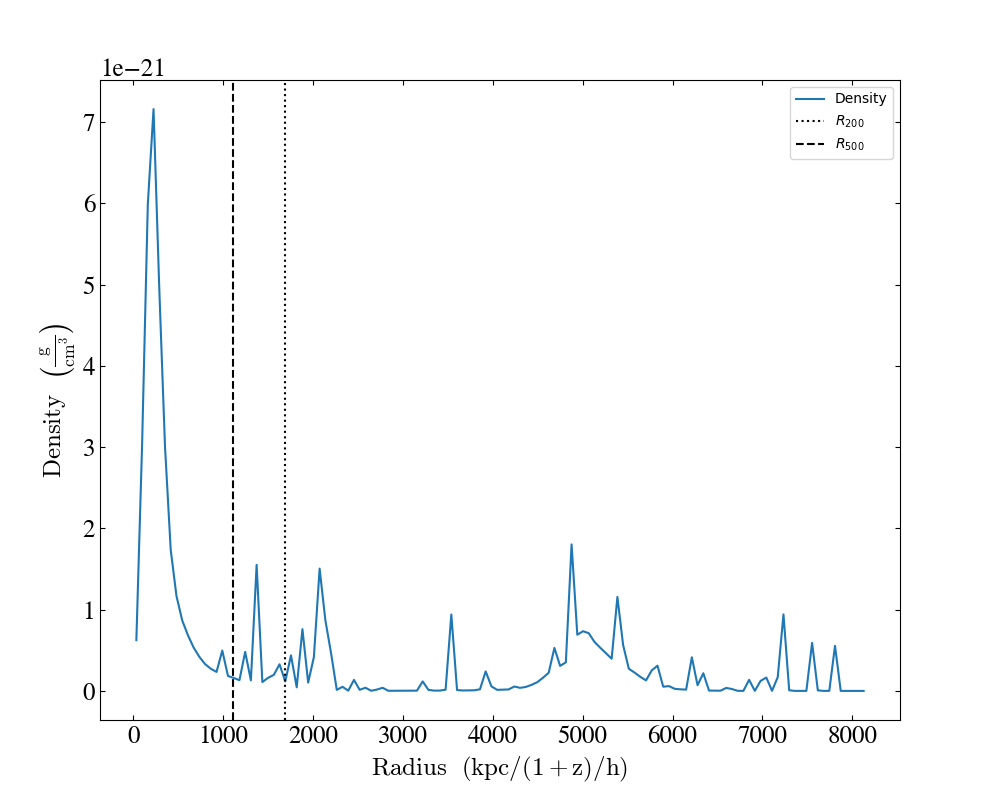

In [9]:
density_prof = yt.ProfilePlot(sp, ("gas", "radius"), [("gas", "density")], weight_field=None, x_log=False, y_log=False, label=["Density"], n_bins=128)
density_prof.set_unit(("gas", "radius"), "kpccm/h")
density_prof.save('/tmp/density_prof') # vertical lines won't display until we've saved/shown the plot
ax = density_prof.plots["gas", "density"].axes
ax.axvline(r200, color='black', label="$R_{200}$", linestyle="dotted")
ax.axvline(r500, color='black', label="$R_{500}$", linestyle="dashed")
ax.legend()
density_prof.display()

yt : [INFO     ] 2023-04-28 15:42:22,109 xlim = 36526.032281 50083.788032
yt : [INFO     ] 2023-04-28 15:42:22,109 ylim = 41569.868218 55127.623969
yt : [INFO     ] 2023-04-28 15:42:22,109 xlim = 36526.027320 50083.781230
yt : [INFO     ] 2023-04-28 15:42:22,110 ylim = 41569.862573 55127.616483
yt : [INFO     ] 2023-04-28 15:42:22,113 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



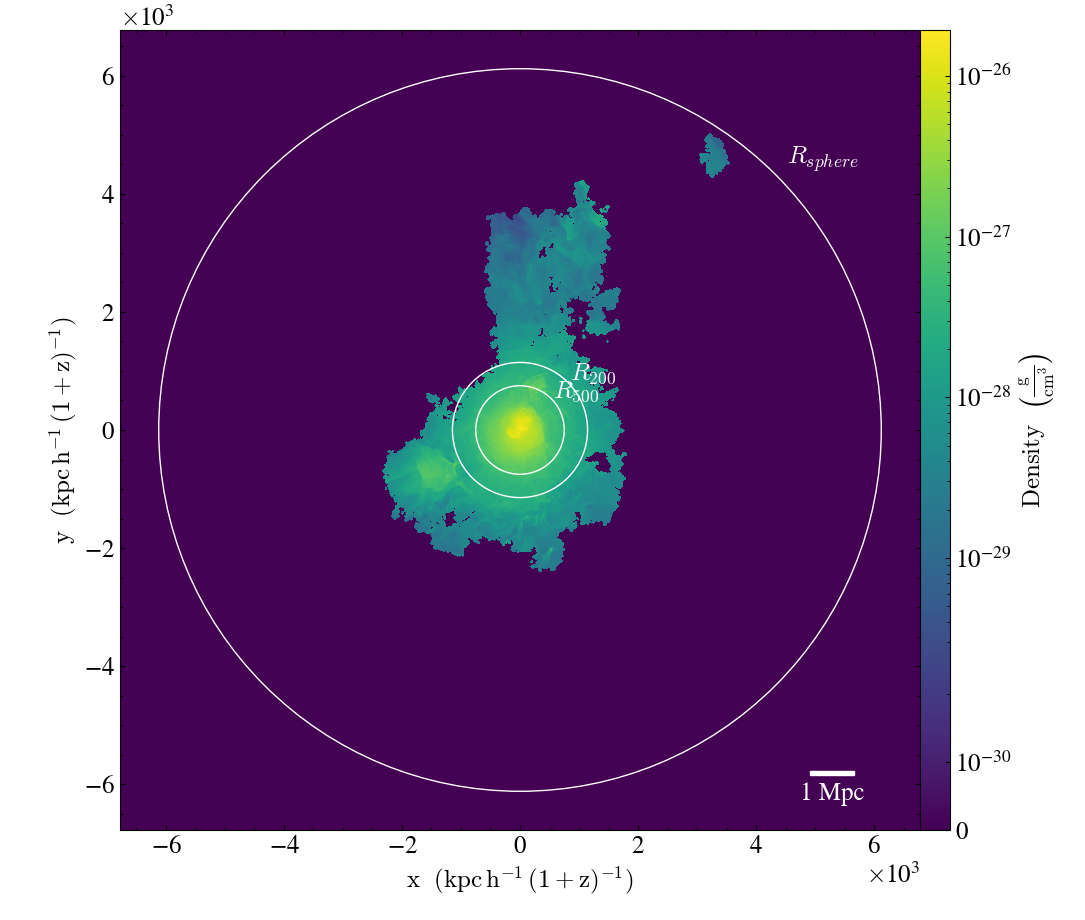

In [10]:
density_slc = yt.SlicePlot(ds, projection_normal, ("gas", "density"), center=center, width=1.5*r)
annotate_spheres(density_slc, center, r200, r500, r)
density_slc.set_cmap(('gas', 'density'), 'viridis')
density_slc.show()
# density_slc.save()

### Gas Temperature

yt : [INFO     ] 2023-04-28 15:42:36,982 xlim = 36526.032281 50083.788032
yt : [INFO     ] 2023-04-28 15:42:36,983 ylim = 41569.868218 55127.623969
yt : [INFO     ] 2023-04-28 15:42:36,984 xlim = 36526.027320 50083.781230
yt : [INFO     ] 2023-04-28 15:42:36,985 ylim = 41569.862573 55127.616483
yt : [INFO     ] 2023-04-28 15:42:36,986 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



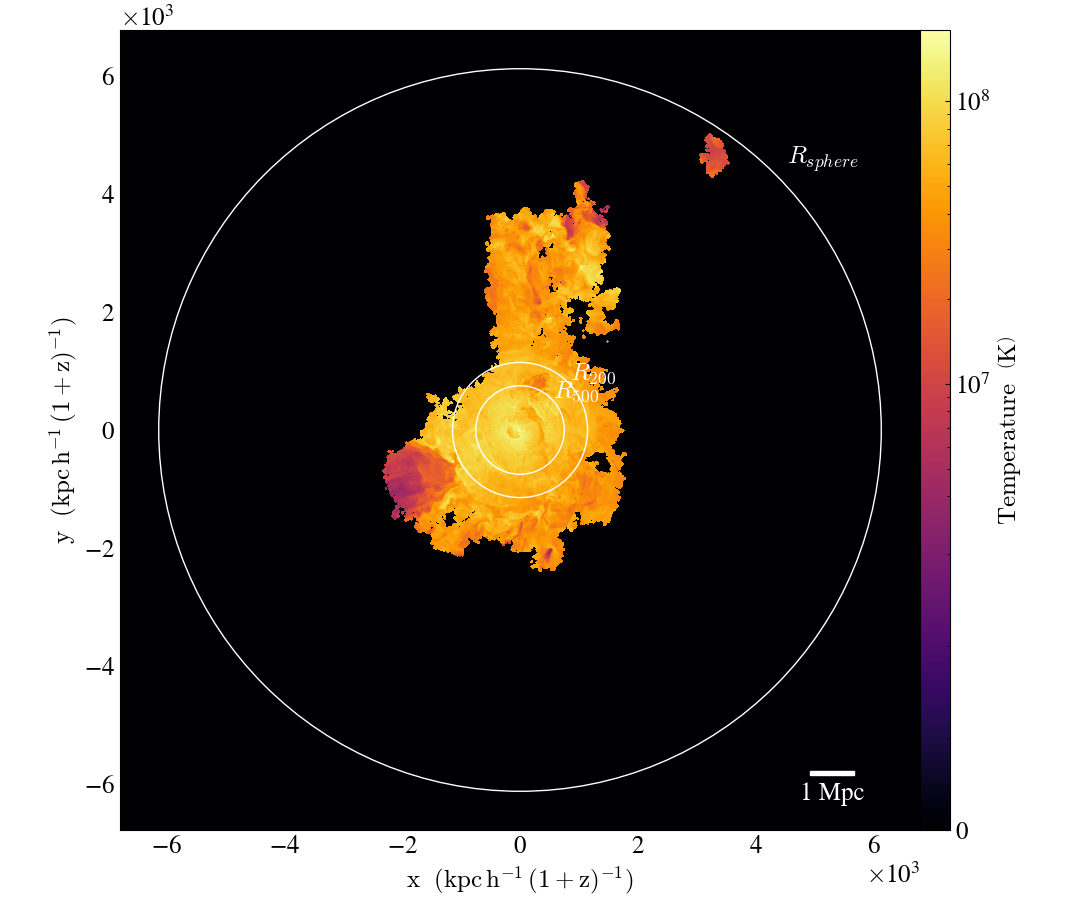

In [11]:
# yt provides syntax to make multiple slice plots at once but it has a bug when we then annotate it.
temperature_slc = yt.SlicePlot(ds, projection_normal, ("gas", "temperature"), center=center, width=1.5*r)
annotate_spheres(temperature_slc, center, r200, r500, r)
temperature_slc.set_cmap(('gas', 'temperature'), 'inferno')
temperature_slc.show()
# temperature_slc.save()

### Gas Column Density

yt : [INFO     ] 2023-04-28 15:42:50,307 xlim = 36526.032281 50083.788032
yt : [INFO     ] 2023-04-28 15:42:50,308 ylim = 41569.868218 55127.623969
yt : [INFO     ] 2023-04-28 15:42:50,308 xlim = 36526.027320 50083.781230
yt : [INFO     ] 2023-04-28 15:42:50,308 ylim = 41569.862573 55127.616483
yt : [INFO     ] 2023-04-28 15:42:50,309 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



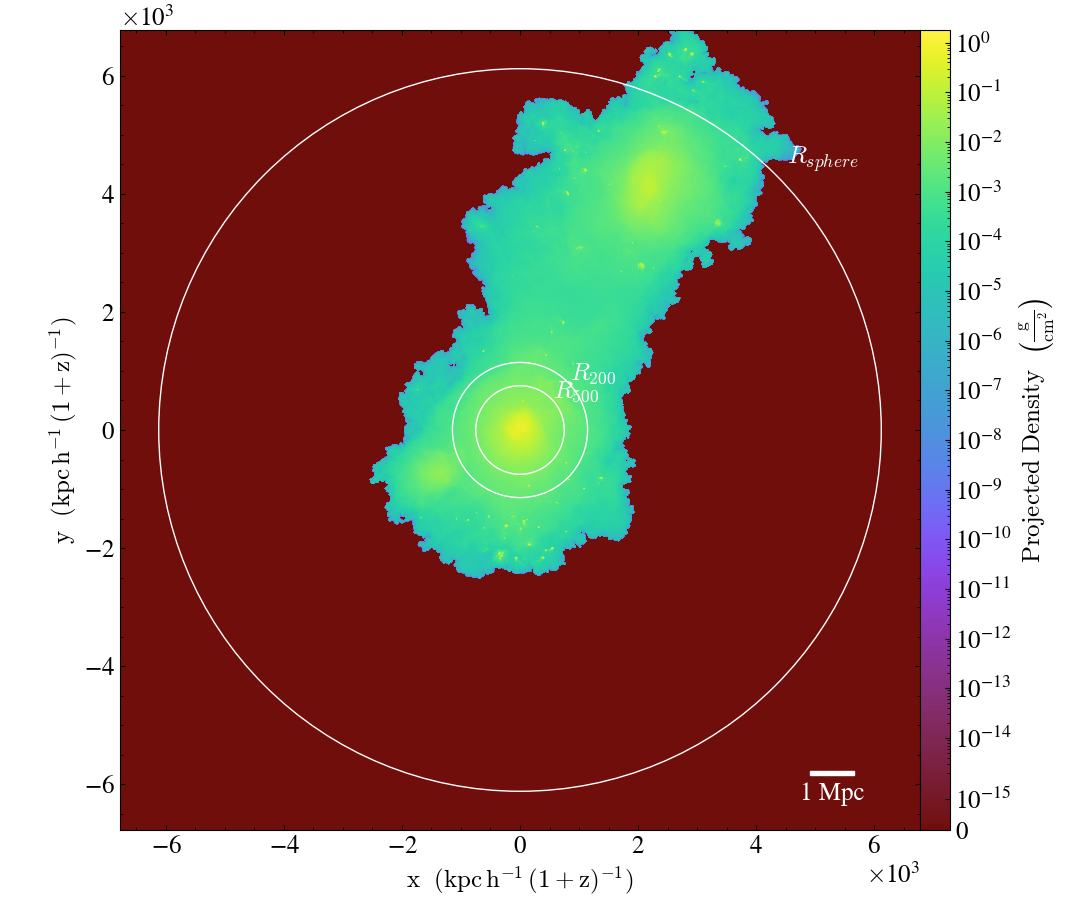

In [12]:
proj = yt.ProjectionPlot(ds, projection_normal, ("gas", "density"), center=center, width=1.5*r)
annotate_spheres(proj, center, r200, r500, r)
proj.show()

## Generate Observations

In [13]:
import pyxsim
import soxs

soxs : [WARNING  ] 2023-04-28 15:43:07,793 Setting 'soxs_data_dir' to /home/ryan/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


**Configure photon generation parameters here**

In [25]:
energy_nbins = 400 # 1100 for detail, but slow # energy bin count for emission model
prefix = f'tng_s{snapshot_id}_h{halo_id}_' # file output path
source_exp_time = (300., "ks") # exposure time for photon generation
area = (1000, "cm**2") # collecting area for photon generation
redshift = ds.current_redshift

In [26]:
# Create output path
from os import makedirs
from pathlib import Path

path = Path(prefix)
makedirs(path.parent, exist_ok=True)

In [27]:
from math import atan, sqrt

pos = (atan(center[0]/center[2]), atan(center[1] / sqrt(center[0]**2 + center[2]**2))) # (RA, Dec)

Load in metallicities and define emission model

In [28]:
var_elem = {
    elem: ("gas", f"{elem}_fraction")
    for elem in
    ["C", "Fe", "H", "He", "Mg", "N", "Ne", "O", "Si"]
}

# Sources uses larger energy range than observations
# Convert metallicity to solar values
source_model = pyxsim.CIESourceModel('apec', emin=0.1, emax=11.0, nbins=energy_nbins, Zmet=('gas', 'solar_metallicity'), var_elem=var_elem)

pyxsim : [INFO     ] 2023-04-28 15:53:45,048 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-04-28 15:53:45,048 kT_max = 64 keV


Generate photon list

In [29]:
n_photons, n_cells = pyxsim.make_photons(prefix + "photons", sp, redshift, area, source_exp_time, source_model)

pyxsim : [INFO     ] 2023-04-28 15:53:45,126 Cosmology: h = 0.6774, omega_matter = 0.3089, omega_lambda = 0.6911
pyxsim : [INFO     ] 2023-04-28 15:53:45,129 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-04-28 15:53:45,131 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/28834570 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-04-28 15:59:13,609 Finished generating photons.
pyxsim : [INFO     ] 2023-04-28 15:59:13,610 Number of photons generated: 41760131
pyxsim : [INFO     ] 2023-04-28 15:59:13,610 Number of cells with photons: 12097756


Project photons

In [30]:
n_events = pyxsim.project_photons(prefix + "photons", prefix + "events", projection_normal, pos, absorb_model="tbabs", nH=0.022)
events = pyxsim.EventList(prefix + "events.h5")
events.write_to_simput(prefix, overwrite=True)

pyxsim : [INFO     ] 2023-04-28 15:59:14,844 Foreground galactic absorption: using the tbabs model and nH = 0.022.


Projecting photons from cells/particles :   0%|          | 0/12097756 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-04-28 15:59:23,459 Detected 23638619 events.
soxs : [INFO     ] 2023-04-28 15:59:24,604 Writing source 'tng_s91_h0_' to tng_s91_h0__phlist.fits.


In [35]:
bg_exp_time = (300., "ks") # for background file
obs_exp_time = (300., "ks")
energy_range = (0.3, 7.0) # of observation

In [36]:
soxs.make_background_file(prefix + "bg.fits", bg_exp_time, "chandra_acisi_cy0", pos, overwrite=True)
soxs.instrument_simulator(prefix + "_simput.fits", prefix + "obs_evt.fits", obs_exp_time, "chandra_acisi_cy0",
                          pos, overwrite=True, bkgnd_file=prefix+'bg.fits')
soxs.write_image(prefix + "obs_evt.fits", prefix + "obs_img.fits", emin=energy_range[0], emax=energy_range[1], overwrite=True)

soxs : [INFO     ] 2023-04-28 16:02:07,100 Adding in point-source background.
soxs : [INFO     ] 2023-04-28 16:02:07,699 Detecting events from source ptsrc_bkgnd.
soxs : [INFO     ] 2023-04-28 16:02:07,700 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2023-04-28 16:02:07,724 Pixeling events.
soxs : [INFO     ] 2023-04-28 16:02:07,739 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2023-04-28 16:02:07,798 61226 events were detected from the source.
soxs : [INFO     ] 2023-04-28 16:02:07,803 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/61226 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-28 16:02:07,964 Generated 61226 photons from the point-source background.
soxs : [INFO     ] 2023-04-28 16:02:07,965 Adding in astrophysical foreground.


Convolving spectrum :   0%|          | 0/937 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-28 16:02:08,417 Adding in instrumental background.
soxs : [INFO     ] 2023-04-28 16:02:08,448 Making 16227 events from the galactic foreground.
soxs : [INFO     ] 2023-04-28 16:02:08,449 Making 364664 events from the instrumental background.
soxs : [INFO     ] 2023-04-28 16:02:08,478 Writing events to file tng_s91_h0_bg.fits.
soxs : [INFO     ] 2023-04-28 16:02:08,608 Making observation of source in tng_s91_h0_obs_evt.fits.
soxs : [INFO     ] 2023-04-28 16:02:09,606 Detecting events from source tng_s91_h0_.
soxs : [INFO     ] 2023-04-28 16:02:09,606 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2023-04-28 16:02:12,874 Pixeling events.
soxs : [INFO     ] 2023-04-28 16:02:14,508 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2023-04-28 16:02:18,223 3731331 events were detected from the source.
soxs : [INFO     ] 2023-04-28 16:02:19,143 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/3731331 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-28 16:02:21,273 Adding background events from the file tng_s91_h0_bg.fits.
soxs : [INFO     ] 2023-04-28 16:02:21,280 Adding 442117 background events from tng_s91_h0_bg.fits.
soxs : [INFO     ] 2023-04-28 16:02:21,342 Writing events to file tng_s91_h0_obs_evt.fits.
soxs : [INFO     ] 2023-04-28 16:02:22,593 Observation complete.


(<Figure size 1000x1000 with 2 Axes>, <WCSAxes: >)

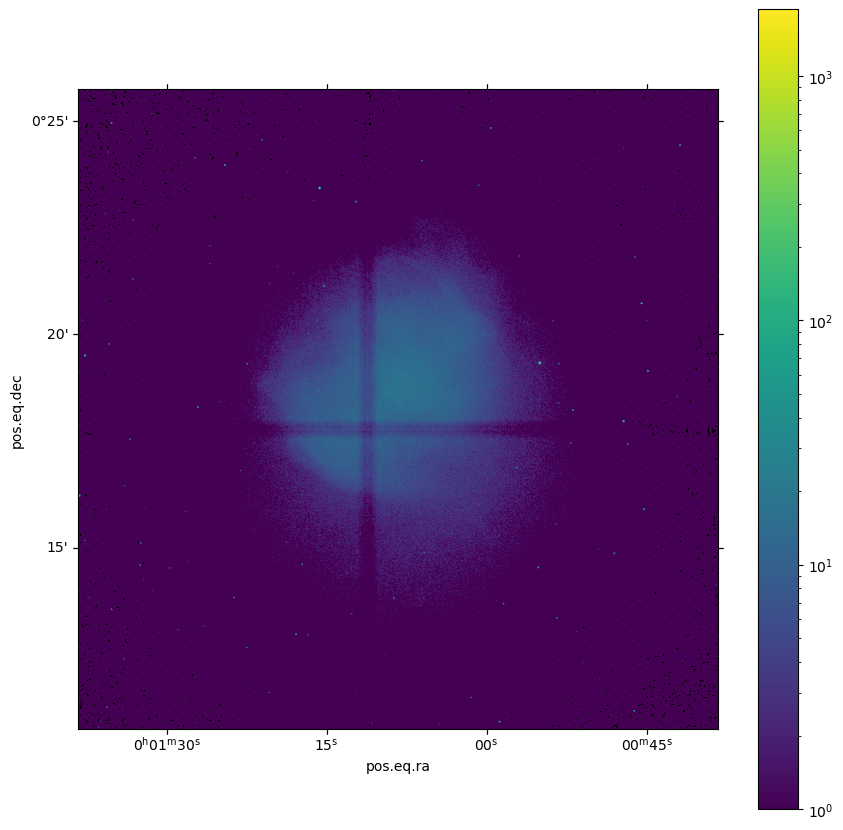

In [37]:
soxs.plot_image(prefix + "obs_img.fits", stretch='log', cmap='viridis', width=0.25)